In [1]:
# https://pccompute.westeurope.cloudapp.azure.com/compute/user/ed.holt@ed.ac.uk/?token=b4c09a5a31134fd1816a5186990e9cab
import pystac_client
import planetary_computer
import stackstac
import numpy as np
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import shape, Point, box
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from xrspatial.multispectral import true_color
import pandas as pd
from itertools import product
import xarray as xr
from PIL import Image
from urllib import request
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [2]:
### define area of interest about a point

aoi_geom = shape({"coordinates":[
          [[-79.62087644492652,9.006625763233117],
            [-79.62087644492652,8.89513941310517],
            [-79.47986008637257,8.89513941310517],
            [-79.47986008637257,9.006625763233117],
            [-79.62087644492652,9.006625763233117]]],
        "type": "Polygon"})

aoi = gpd.GeoDataFrame(geometry=[aoi_geom], crs=4326)

### get images
grab satellite acquisionts from sentinel 1 and 2 that intersect with study area
for sentinel 2 filter on cloud cover to deliberately select images with > 50% cloud

In [3]:
############# sentinel 1 acquisitions
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections=['sentinel-1-rtc'],
                        intersects=aoi_geom,
                        datetime="2021-01-01/2023-09-30")
s1_items = search.item_collection()
epsg = set([item.properties['proj:epsg'] for item in s1_items])
print(f'found {len(s1_items)} S1 items\nwith the following epsgs: {epsg}')


################# sentinel 2 scenes
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections=["sentinel-2-l2a"],
                        intersects=aoi_geom,
                        datetime="2021-01-01/2023-09-30",
                        query={"eo:cloud_cover":{'gt':40,
                                                 'lt':70}})

s2_items = search.item_collection()
epsg = set([item.properties['proj:epsg'] for item in s2_items])
print(f'found {len(s2_items)} S2 items\nwith the following epsgs: {epsg}')

found 160 S1 items
with the following epsgs: {32617}
found 73 S2 items
with the following epsgs: {32617}


s2 image has 59.9% cloud coverage
Sentinel 1: 29-04-2023 at 11:06
Sentinel 2: 29-04-2023 at 15:45
Sentinel 1
4 hours 38 minutes earlier


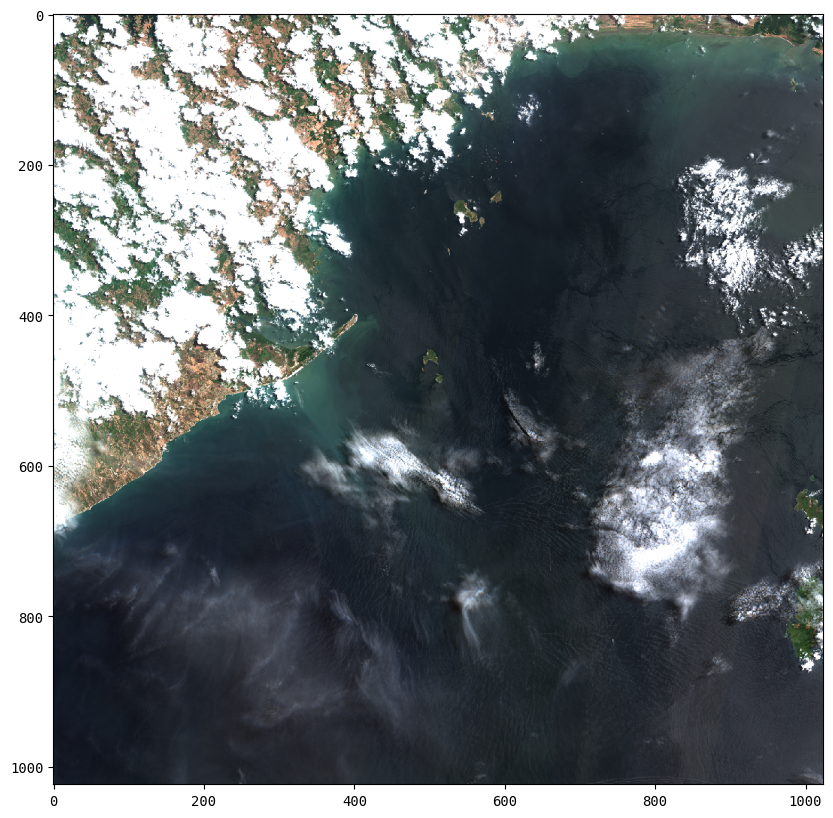

In [4]:
### find the time difference between each pair of s1 and s2 images
s1_dates = [pd.to_datetime(i.properties['datetime']) for i in s1_items]
s2_dates = [pd.to_datetime(i.properties['datetime']) for i in s2_items]
img_pairs_time = [(i,np.abs(dates[1] - dates[0])) for i, dates in enumerate(product(s1_dates,s2_dates))]

## get true/false of whether the intersection of the footprints of each s1 and s2 pair contain the AOI geometry
img_pairs = list(product(list(s1_items), list(s2_items)))
contains = [(shape(_s1.to_dict()['geometry']).intersection(shape(_s2.to_dict()['geometry']))).contains(aoi_geom) for _s1, _s2 in img_pairs]
contains_idx = [i for i,t in enumerate(contains) if t]
df = pd.DataFrame([img_pairs_time[i] for i in contains_idx], columns=['idx','t_diff'])

## combine the indicies to get the minimum time difference where the footprints both wholly contain the aoi
if len(df) == 0:
    print('will not work')
else:    
    idx = df.loc[df['t_diff'].idxmin(),'idx']

    s1_date, s2_date = list(product(s1_dates, s2_dates))[idx]
    s1_item, s2_item = img_pairs[idx]
    #########################
    
    print(f"s2 image has {np.round(s2_item.properties['eo:cloud_cover'],1)}% cloud coverage")

    ### plot the image
    _,ax=plt.subplots(figsize=[10,10])
    ax.imshow(np.array(Image.open(request.urlopen(s2_item.assets['rendered_preview'].href))))

    ## get time difference between them
    hours, remainder = divmod((s2_date - s1_date).total_seconds(), 3600)
    minutes, seconds = divmod(remainder, 60)
    print(s1_date.strftime('Sentinel 1: %d-%m-%Y at %H:%M'))
    print(s2_date.strftime('Sentinel 2: %d-%m-%Y at %H:%M'))

    if s1_date < s2_date:
        title = f'Sentinel 1\n{hours:.0f} hours {minutes:.0f} minutes earlier'
    else:
        hours = -1*hours
        title = f'Sentinel 1\n{hours:.0f} hours {minutes:.0f} minutes later'
    print(title)

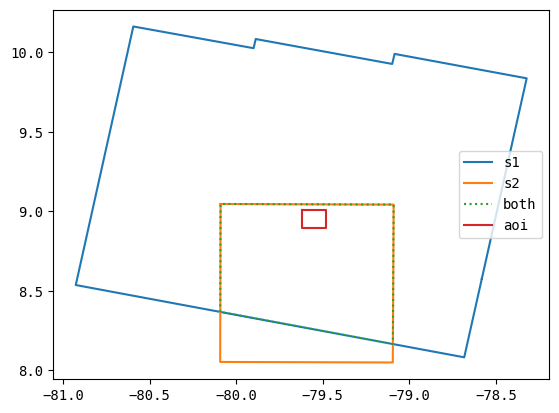

In [5]:
#### define common projection, and bbox intersection
epsg_code = s2_item.properties['proj:epsg']
prj = ccrs.epsg(epsg_code)

s1_geo = shape(s1_item.to_dict()['geometry'])
s2_geo = shape(s2_item.to_dict()['geometry'])

intersection = s1_geo.intersection(s2_geo)
intersection_prj = gpd.GeoDataFrame(geometry=[intersection],crs=4326).to_crs(prj)['geometry'][0]
aoi_prj = gpd.GeoDataFrame(geometry=[aoi_geom],crs=4326).to_crs(prj)['geometry'][0]

# ### check intersection is good
fig, ax = plt.subplots()
ax.plot(*s1_geo.exterior.coords.xy, label='s1')
ax.plot(*s2_geo.exterior.coords.xy, label='s2')
ax.plot(*intersection.exterior.coords.xy, label='both', linestyle=':')
ax.plot(*aoi_geom.exterior.coords.xy, label='aoi')
ax.legend()
# gpd.GeoDataFrame(geometry=[intersection],crs=4326).explore()

In [6]:
### get image arrays and clip them
s1 = (stackstac.stack(planetary_computer.sign(s1_item),
                      epsg=epsg_code)
      .rio.clip_box(*aoi_prj.bounds))[0,:,:,:]

s2 = (rio.open_rasterio(s2_item.assets['visual'].href)
      .rio.clip_box(*aoi_prj.bounds))

### for sentinel 1: convert rtc to decibels and compute ratio of polarisations
### merge into one common dataset and normalize each band to between 0 and 1 (for the sake of plt.imshow())

# s1db = 10*np.log10(s1.coarsen({'x':10,'y':10}, boundary='trim').mean()).compute()

s1db = 10 * np.log10(s1)
ratio = s1db[1,:,:] / s1db[0,:,:].expand_dims({'band':['ratio']})

### drop coords that aren't in common - if you don't do this xr.concat() doesn't work
coords=[]
for coord in s1db.coords:
    if coord not in ratio.coords:
        coords.append(coord)
s1db = s1db.drop(coords)

s1_concat = xr.concat([s1db, ratio],
                      dim='band',
                      coords='minimal',
                      compat='override')

# normalize bands
s1_false = ((s1_concat - s1_concat.min(skipna=True,
                                  dim=['y','x'])) / (s1_concat.max(skipna=True,
                                                                   dim=['y','x']) - s1_concat.min(skipna=True,
                                                                                                  dim=['y','x']))).compute()

############ for s2
#### tweak rgb bands for nicer plotting
s2_true_color = true_color(*s2,nodata=np.nan).compute()

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Text(0.01, -0.04, 'by:tlohde')

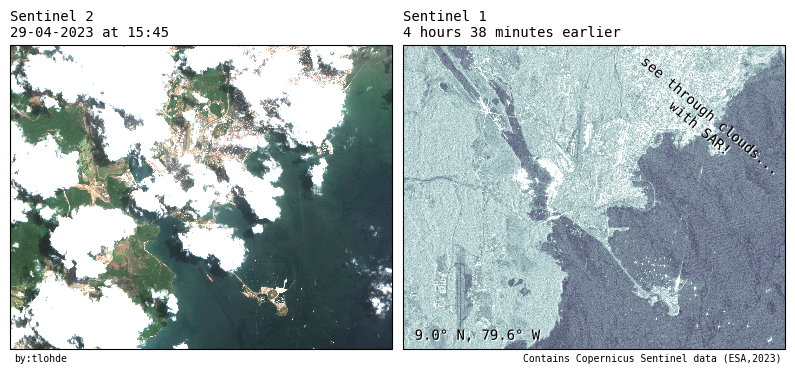

In [9]:
import matplotlib.patheffects as path_effects
fig, axs = plt.subplots(ncols=2, #sharex=True, sharey=True,
                        figsize=[10,8],
                        subplot_kw={'projection':prj})

# s2_true_color.plot.imshow(rgb='band', ax=axs[0])
s2.plot.imshow(rgb='band', ax=axs[0])

s1db[1,:,:].plot(cmap='bone', vmin=-40, vmax=1, ax=axs[1], add_colorbar=False)
# s1_false.plot.imshow(rgb='band', ax=axs[1])

for ax in axs:
    ax.set_facecolor('k')
    ax.set_title('')

axs[0].set_title(s2_date.strftime('Sentinel 2\n%d-%m-%Y at %H:%M'), loc='left',**{'fontsize':10})
axs[1].set_title(title, loc='left',**{'fontsize':10})

axs[1].annotate(text='see through clouds...\nwith SAR!',
                xy=(0.79,0.53), xycoords='axes fraction',
                ha='center', rotation=-40, c='k',
                path_effects=[path_effects.withSimplePatchShadow(shadow_rgbFace='w',
                                                                 alpha=0.9,
                                                                 offset=(1,-1))])

## fpr correctly plotting coordinates
p = gpd.GeoSeries(box(*s1_false.rio.bounds()).centroid,crs=prj).to_crs(4326)[0]

if p.y < 0:
    Y = p.y * -1
    ns = 'S'
else:
    Y = p.y
    ns = 'N'
    
if p.x < 0:
    X = p.x * -1
    ew = 'W'
else:
    X = p.x
    ew = 'E'

axs[1].annotate(text=(f'{Y:.1f}° {ns}, {X:.1f}° {ew}'),
    xy=(0.03,0.03), xycoords='axes fraction',
    c='k', ha='left', fontsize=10,
    path_effects=[path_effects.withSimplePatchShadow(shadow_rgbFace='w',
                                                                 alpha=0.9,
                                                                 offset=(1,-1))])

plt.subplots_adjust(wspace=0.03)
axs[1].annotate(text='Contains Copernicus Sentinel data (ESA,2023)',
            xy=(0.99,-0.04), xycoords='axes fraction', 
            ha='right', fontsize=7)
axs[0].annotate(text='by:tlohde',
            xy=(0.01,-0.04), xycoords='axes fraction',
            ha='left', fontsize=7)

In [8]:
# fig.savefig('day18_panama_c.png', bbox_inches='tight', dpi=300)